In [ ]:
%pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [ ]:
# libraries required for training and running the classifiers
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

In [ ]:
# libraries required for data preprocessing
# min-max scaling for scaling
from sklearn.preprocessing import MinMaxScaler
# smote for oversampling
from imblearn.over_sampling import SMOTE
# data shuffling
from sklearn.utils import shuffle

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# imports
import time
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.stats import uniform, poisson

In [ ]:
X_train, y_train = pd.read_csv('CompleteDataSet/x_train_all.csv'), pd.read_csv('CompleteDataSet/y_train_all.csv')

In [ ]:
X_test, y_test = pd.read_csv('CompleteDataSet/x_test_all.csv'), pd.read_csv('CompleteDataSet/y_test_all.csv')

Data Pre-processing

In [ ]:
# renaming the column name in y_train from '0' to 'label'
y_train.rename(columns={'0':'label'}, inplace=True)
y_test.rename(columns={'0':'label'}, inplace=True)

Scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Shuffling

In [ ]:
X_train_shuffled = shuffle(X_train_scaled, random_state = 42)
X_test_shuffled = shuffle(X_test_scaled, random_state = 42)
Y_train_shuffled = shuffle(y_train, random_state = 42)
Y_test_shuffled = shuffle(y_test, random_state = 42)

In [ ]:
X_train_shuffled = pd.DataFrame(X_train_shuffled)

Performing Oversampling to ensure balanced dataset

In [ ]:
# Oversampling
smote = SMOTE(random_state=42)  # You can specify different options if needed

# Apply SMOTE to generate synthetic samples
X_resampled, y_resampled = smote.fit_resample(X_train_shuffled, Y_train_shuffled)

using train-test split to get a smaller subset of the training data

In [ ]:
X_train_stratified, X_test_stratified, y_train_stratified, y_test_stratified = train_test_split( X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

In [ ]:
y_train_stratified.value_counts()

label
0        1575
1        1575
2        1575
3        1575
4        1575
5        1575
6        1575
7        1575
8        1575
9        1575
dtype: int64

Decision Tree Classifier

In [ ]:
# Create a DecisionTreeClassifier (J48-like)
clf_random = DecisionTreeClassifier(random_state=42)

In [ ]:
# Helper function to plot ROC curves
def plot_roc_for_classes(true_bin_labels, score, classes, title="ROC Curve"):
    n_classes = len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_bin_labels[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Helper function to find specificity
def specificity(cm):
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    specificity = TN/(TN+FP)
    return np.mean(specificity)

# Helper functions to print overall metrics
def print_overall_metrics(true_labels, pred_labels):
    acc = accuracy_score(true_labels, pred_labels)
    presc = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(true_labels, pred_labels, average='weighted', zero_division=1)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=1)
    tpr = rec
    # Calculate FPR correctly using roc_curve
    s = specificity(confusion_matrix(true_labels, pred_labels))
    fpr = 1 - s

    print('Accuracy:', acc)
    print('Precision:', presc)
    print('Recall (TPR):', tpr)
    print('False Positive Rate (FPR):', fpr)
    print('F1 score (F-measure):', f1)
    print('Specificity:', s)
    print("------------------------------------------------------------------------------------------------")

# Helper functions to print class-wise metrics
def get_classwise_metrics_dataframe(true_labels, pred_labels, unique_labels):
    metrics_data = []
    matrix = confusion_matrix(true_labels, pred_labels, labels=unique_labels)

    for i, label in enumerate(unique_labels):
        tp = matrix[i, i]
        fp = np.sum(matrix[:, i]) - tp
        fn = np.sum(matrix[i, :]) - tp
        tn = np.sum(matrix) - tp - fp - fn

        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tpr
        f_measure = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)

        metrics_data.append([label, accuracy, precision, recall, fpr, f_measure, tp, fp, tn, fn])

    df = pd.DataFrame(metrics_data, columns=['Class', 'Accuracy', 'Precision', 'Recall (TPR)', 'FPR', 'F1 Score (F-measure)', 'TP', 'FP', 'TN', 'FN'])

    return df

# Helper function to plot confusion matrix
def plot_confusion_matrix(matrix, dataset_name, unique_labels):
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks + 0.5, unique_labels, rotation=45)  # +0.5 to center the label
    plt.yticks(tick_marks + 0.5, unique_labels)  # +0.5 to center the label
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix')
    plt.show()

In [ ]:
def runclassifier(model, X_train, y_train, X_test, y_test):

    labels_series = y_train['label']
    unique_labels = sorted(labels_series.unique())

    # Binarize the labels for ROC curve generation
    y_train_bin = label_binarize(y_train, classes=unique_labels)
    y_test_bin = label_binarize(y_test, classes=unique_labels)

    model.fit(X_train, y_train)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=10)
    y_test_pred = model.predict(X_test)

    # Overall metrics for training set
    print("Overall Metrics for Training set:")
    print("------------------------------------------------------------------------------------------------")
    print_overall_metrics(y_train, y_train_pred)

    # Display metrics in tabular format for each class
    classwise_df_train = get_classwise_metrics_dataframe(y_train, y_train_pred, unique_labels)
    print("\nClasswise Metrics for Training Set:")
    display(classwise_df_train)

    print("------------------------------------------------------------------------------------------------")
    print("Confusion Matrix for Train Set")
    print("------------------------------------------------------------------------------------------------")
    plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), 'Training Set', unique_labels)
    print("------------------------------------------------------------------------------------------------")
    print("ROC Curve for Train Set")
    print("------------------------------------------------------------------------------------------------")
    plot_roc_for_classes(y_train_bin, model.predict_proba(X_train), unique_labels, title="ROC Curve (Training Data)")
    print("------------------------------------------------------------------------------------------------")
    # Overall metrics for test set
    print("\nOverall Metrics for Test set:")
    print("------------------------------------------------------------------------------------------------")
    print_overall_metrics(y_test, y_test_pred)

    # Display metrics in tabular format for each class
    classwise_df_test = get_classwise_metrics_dataframe(y_test, y_test_pred, unique_labels)
    print("\nClasswise Metrics for Test Set:")
    display(classwise_df_test)

    print("------------------------------------------------------------------------------------------------")
    print("Confusion Matrix for Test Set")
    print("------------------------------------------------------------------------------------------------")
    plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), 'Test Set', unique_labels)
    print("------------------------------------------------------------------------------------------------")
    print("ROC Curve for Test Set")
    print("------------------------------------------------------------------------------------------------")
    plot_roc_for_classes(y_test_bin, model.predict_proba(X_test), unique_labels, title="ROC Curve (Test Data)")

     # Create metrics dictionary
    metrics_dict = {
        "Model": model.__class__.__name__,
        "Test Metrics": {
            "Accuracy": accuracy_score(y_test, y_test_pred),
            "Precision": precision_score(y_test, y_test_pred, average='weighted',zero_division=0),
            "Recall": recall_score(y_test, y_test_pred,average='weighted'),
            "F1 score": f1_score(y_test, y_test_pred, average='weighted'),
            "TP": confusion_matrix(y_test, y_test_pred).sum(axis=1),
            "FP": confusion_matrix(y_test, y_test_pred).sum(axis=0) - np.diag(confusion_matrix(y_test, y_test_pred)),
            "TN": confusion_matrix(y_test, y_test_pred).sum() - (confusion_matrix(y_test, y_test_pred).sum(axis=1) + confusion_matrix(y_test, y_test_pred).sum(axis=0)),
            "FN": np.diag(confusion_matrix(y_test, y_test_pred)),
            "Sensitivity (TPR)": recall_score(y_test, y_test_pred, average='weighted'),
            "Specificity": specificity(confusion_matrix(y_test, y_test_pred)),
            "FPR": 1 - specificity(confusion_matrix(y_test, y_test_pred))
        }
    }

    return metrics_dict

### Running Decision trees on the training set with and without cross-validation.

### Without Cross-Validation

Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 1.0
Precision: 1.0
Recall (TPR): 1.0
False Positive Rate (FPR): 0.0
F1 score (F-measure): 1.0
Specificity: 1.0
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
1,1,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
2,2,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
3,3,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
4,4,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
5,5,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
6,6,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
7,7,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
8,8,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
9,9,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


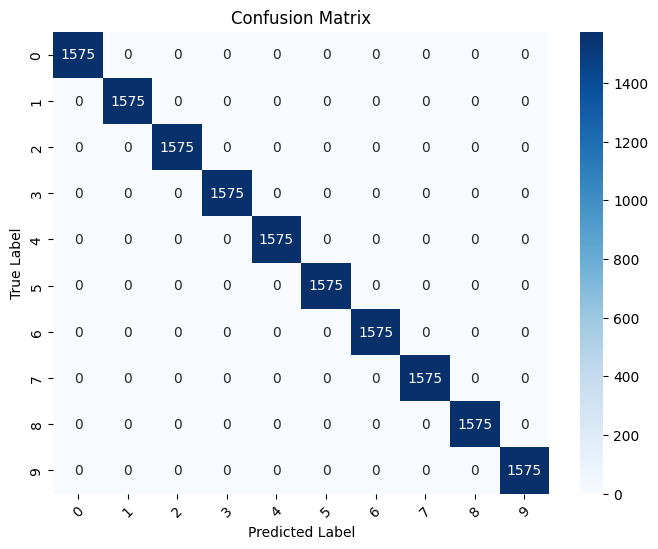

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


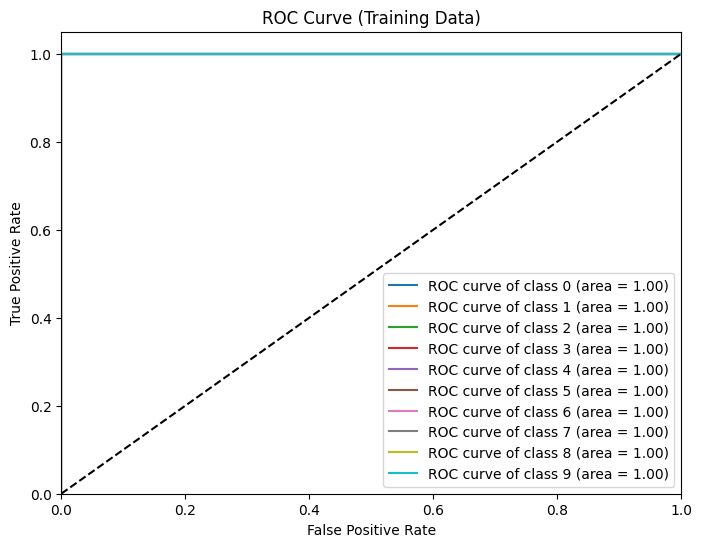

In [ ]:
labels_series = y_train_stratified['label']
unique_labels = sorted(labels_series.unique())

# Binarize the labels for ROC curve generation
y_train_bin = label_binarize(y_train_stratified, classes=unique_labels)

# Without Cross-Validation
clf_random.fit(X_train_stratified, y_train_stratified)

# Make predictions on the test data
y_train_pred = clf_random.predict(X_train_stratified)

# Overall metrics for training set
print("Overall Metrics for Training set:")
print("------------------------------------------------------------------------------------------------")
print_overall_metrics(y_train_stratified, y_train_pred)

# Display metrics in tabular format for each class
classwise_df_train = get_classwise_metrics_dataframe(y_train_stratified, y_train_pred, unique_labels)
print("\nClasswise Metrics for Training Set:")
display(classwise_df_train)

print("------------------------------------------------------------------------------------------------")
print("Confusion Matrix for Train Set")
print("------------------------------------------------------------------------------------------------")
plot_confusion_matrix(confusion_matrix(y_train_stratified, y_train_pred), 'Training Set', unique_labels)
print("------------------------------------------------------------------------------------------------")
print("ROC Curve for Train Set")
print("------------------------------------------------------------------------------------------------")
plot_roc_for_classes(y_train_bin, clf_random.predict_proba(X_train_stratified), unique_labels, title="ROC Curve (Training Data)")

## With 10-fold cross-validation

Decision Tree performance for Training and Testing dataset with 10-fold crossvalidation
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.910984126984127
Precision: 0.9099916383714614
Recall (TPR): 0.910984126984127
False Positive Rate (FPR): 0.009890652557319135
F1 score (F-measure): 0.9104157175599822
Specificity: 0.9901093474426809
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.992889,0.951822,0.978413,0.005503,0.964934,1541,78,14097,34
1,1,0.960571,0.814644,0.784127,0.019824,0.799094,1235,281,13894,340
2,2,0.956635,0.788860,0.773333,0.022998,0.781020,1218,326,13849,357
3,3,0.975492,0.876504,0.878730,0.013757,0.877616,1384,195,13980,191
4,4,0.972063,0.866365,0.852063,0.014603,0.859155,1342,207,13968,233
5,5,0.995683,0.971232,0.986032,0.003245,0.978576,1553,46,14129,22
6,6,0.991683,0.956384,0.960635,0.004868,0.958505,1513,69,14106,62
7,7,0.995810,0.976627,0.981587,0.002610,0.979101,1546,37,14138,29
8,8,0.989587,0.942875,0.953651,0.006420,0.948232,1502,91,14084,73
9,9,0.991556,0.954603,0.961270,0.005079,0.957925,1514,72,14103,61


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


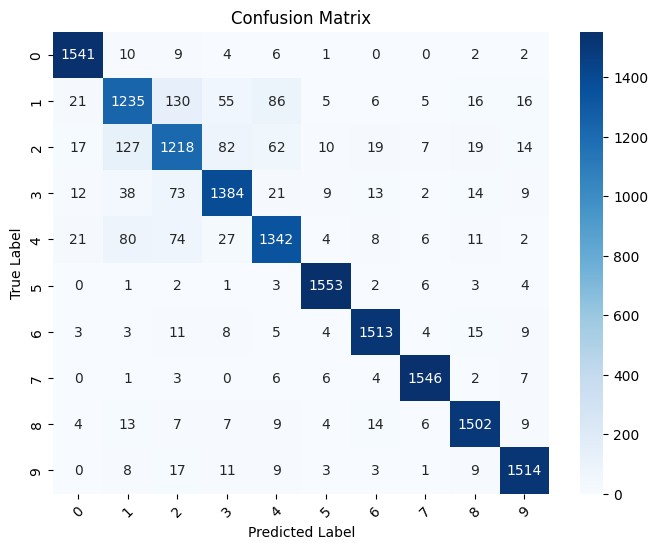

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


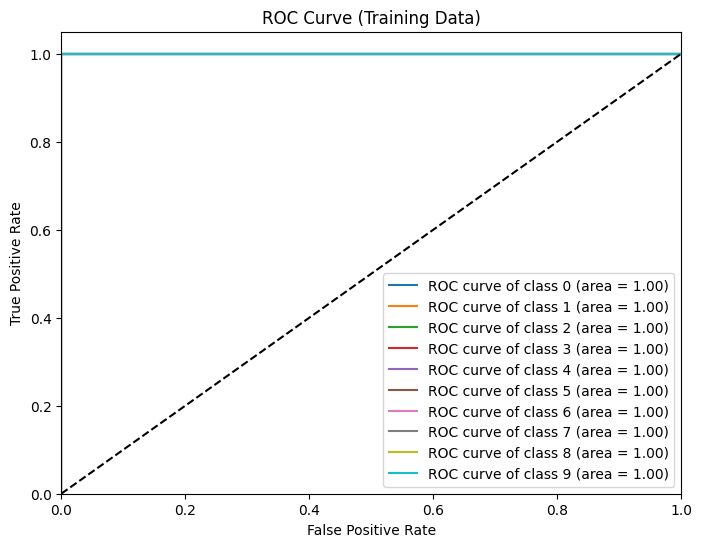

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6540453074433656
Precision: 0.6584266313591915
Recall (TPR): 0.6540453074433656
False Positive Rate (FPR): 0.042129276988871034
F1 score (F-measure): 0.6551121523500959
Specificity: 0.957870723011129
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.969903,0.291139,0.383333,0.018482,0.330935,23,56,2974,37
1,1,0.840777,0.644304,0.706944,0.118565,0.674172,509,281,2089,211
2,2,0.855016,0.705722,0.690667,0.092308,0.698113,518,216,2124,232
3,3,0.907120,0.694511,0.646667,0.048485,0.669735,291,128,2512,159
4,4,0.873463,0.717286,0.672727,0.072016,0.694292,444,175,2255,216
5,5,0.986731,0.693878,0.566667,0.004950,0.623853,34,15,3015,26
6,6,0.973139,0.540230,0.522222,0.013333,0.531073,47,40,2960,43
7,7,0.978641,0.444444,0.400000,0.009901,0.421053,24,30,3000,36
8,8,0.953074,0.514124,0.606667,0.029252,0.556575,91,86,2854,59
9,9,0.970227,0.487805,0.444444,0.014000,0.465116,40,42,2958,50


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


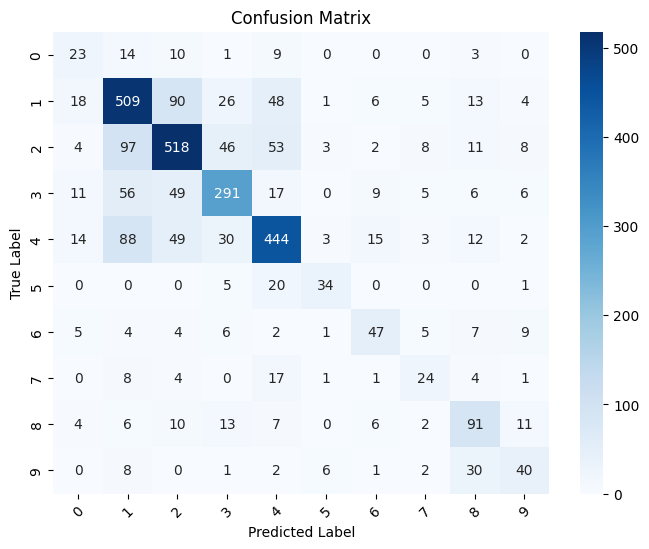

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


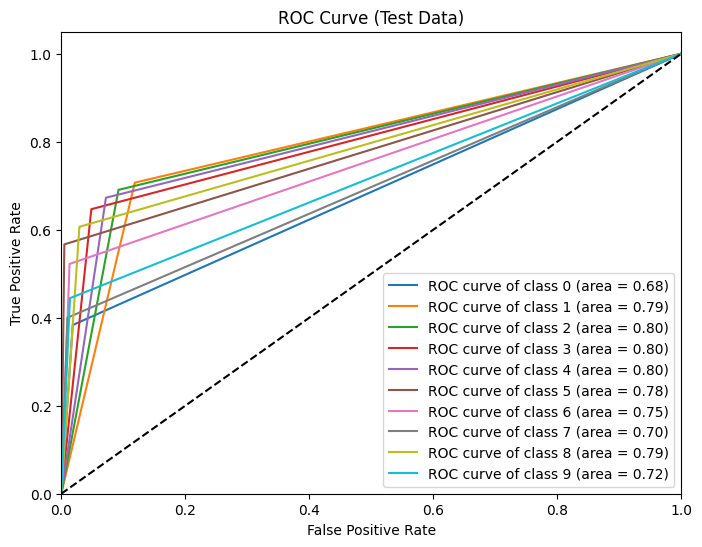

In [ ]:
print("Decision Tree performance for Training and Testing dataset with 10-fold crossvalidation")
print("------------------------------------------------------------------------------------------------")
dt_result_cv = runclassifier(clf_random,X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

The highest accuracy and F1-Score achieved by the testing dataset is 65% and 0.65 which we intend to improve upon hyperparameter optimization.

The initial model performance on the training data without cross-validation showed perfect scores, which is a strong indicator of overfitting. Overfitting occurs when a model learns the training data too well, including noise and outliers, which leads to poor generalization to new, unseen data.

The application of 10-fold cross-validation provided a more accurate estimate of the model's ability to generalize, as it trained and evaluated the model on multiple subsets of the data. The variation in the AUC scores for the test data, as seen in the ROC curves, further confirms that while the model performs well on the training data, its performance on unseen data can vary, which is a more realistic scenario.

Cross-validation helped in mitigating the overfitting issue by ensuring the model is not overly tuned to the specific quirks of the training set.

The discrepancy in performance between the training and testing sets is a classic symptom of overfitting. The model's ability to almost perfectly classify the training data was not fully replicated on the testing data, which is more representative of real-world performance.

## HyperParameter Tuning

Decision Tree hyperparamters :

* max_depth
* min_sample_split
* min_sample_leaf
* criterion

## GridSearch CV

In [ ]:
def parametertuning(param_grid, X_train, y_train, X_test, y_test):

  labels_series = y_train['label']
  unique_labels = sorted(labels_series.unique())

  # Binarize the labels for ROC curve generation
  y_train_bin = label_binarize(y_train, classes=unique_labels)
  y_test_bin = label_binarize(y_test, classes=unique_labels)

  dt_clf = DecisionTreeClassifier(random_state=42)
  # GridSearch
  grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  # Get the best parameter setting
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  print("Best Parameters:", best_params)
  y_test_pred = best_model.predict(X_test)

  # Overall metrics for test set
  print("\nOverall Metrics for Test set:")
  print("------------------------------------------------------------------------------------------------")
  print_overall_metrics(y_test, y_test_pred)

  # Display metrics in tabular format for each class
  classwise_df_test = get_classwise_metrics_dataframe(y_test, y_test_pred, unique_labels)
  print("\nClasswise Metrics for Test Set:")
  display(classwise_df_test)

#  print("------------------------------------------------------------------------------------------------")
#  print("Confusion Matrix for Test Set")
#  print("------------------------------------------------------------------------------------------------")
#  plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), 'Test Set', unique_labels)
 # print("------------------------------------------------------------------------------------------------")
 # print("ROC Curve for Test Set")
 # print("------------------------------------------------------------------------------------------------")
 # plot_roc_for_classes(y_test_bin, best_model.predict_proba(X_test), unique_labels, title="ROC Curve (Test Data)")

  # Create metrics dictionary
  metrics_dict = {
      "Model": best_model.__class__.__name__,
      "Test Metrics": {
          "Accuracy": accuracy_score(y_test, y_test_pred),
          "Precision": precision_score(y_test, y_test_pred, average='weighted',zero_division=0),
          "Recall": recall_score(y_test, y_test_pred,average='weighted'),
          "F1 score": f1_score(y_test, y_test_pred, average='weighted'),
          "TP": confusion_matrix(y_test, y_test_pred).sum(axis=1),
          "FP": confusion_matrix(y_test, y_test_pred).sum(axis=0) - np.diag(confusion_matrix(y_test, y_test_pred)),
          "TN": confusion_matrix(y_test, y_test_pred).sum() - (confusion_matrix(y_test, y_test_pred).sum(axis=1) + confusion_matrix(y_test, y_test_pred).sum(axis=0)),
          "FN": np.diag(confusion_matrix(y_test, y_test_pred)),
          "Sensitivity (TPR)": recall_score(y_test, y_test_pred, average='weighted'),
          "Specificity": specificity(confusion_matrix(y_test, y_test_pred)),
          "FPR": 1 - specificity(confusion_matrix(y_test, y_test_pred))
          }
      }

  return metrics_dict

### Maximum Depth

In [ ]:
max_depth_grid = {
    'max_depth':np.arange(1,21).tolist()[0::2],
}
print("For Checking the Maximum depth for the decision tree")
print("----------------------------------------------------------------------------")
depth_result_1 = parametertuning(max_depth_grid,X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Maximum depth for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'max_depth': 19}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6779935275080906
Precision: 0.6835936650568223
Recall (TPR): 0.6779935275080906
False Positive Rate (FPR): 0.03921882534595722
F1 score (F-measure): 0.6793679915924568
Specificity: 0.9607811746540428
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.970550,0.308642,0.416667,0.018482,0.354610,25,56,2974,35
1,1,0.849838,0.667102,0.709722,0.107595,0.687752,511,255,2115,209
2,2,0.856958,0.701044,0.716000,0.097863,0.708443,537,229,2111,213
3,3,0.918770,0.736342,0.688889,0.042045,0.711825,310,111,2529,140
4,4,0.887055,0.761345,0.686364,0.058436,0.721912,453,142,2288,207
5,5,0.985761,0.653846,0.566667,0.005941,0.607143,34,18,3012,26
6,6,0.975081,0.582278,0.511111,0.011000,0.544379,46,33,2967,44
7,7,0.985437,0.605634,0.716667,0.009241,0.656489,43,28,3002,17
8,8,0.954693,0.527473,0.640000,0.029252,0.578313,96,86,2854,54
9,9,0.971845,0.519481,0.444444,0.012333,0.479042,40,37,2963,50


###  Minimum number of samples required to split an internal node





In [ ]:
min_sample_split_grid = {
  'min_samples_split':np.arange(2,11).tolist()[0::2],
}
print("For Checking the Minimum number of splits for the decision tree")
print("----------------------------------------------------------------------------")
split_result = parametertuning(min_sample_split_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Minimum number of splits for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'min_samples_split': 2}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6540453074433656
Precision: 0.6584266313591915
Recall (TPR): 0.6540453074433656
False Positive Rate (FPR): 0.042129276988871034
F1 score (F-measure): 0.6551121523500959
Specificity: 0.957870723011129
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.969903,0.291139,0.383333,0.018482,0.330935,23,56,2974,37
1,1,0.840777,0.644304,0.706944,0.118565,0.674172,509,281,2089,211
2,2,0.855016,0.705722,0.690667,0.092308,0.698113,518,216,2124,232
3,3,0.907120,0.694511,0.646667,0.048485,0.669735,291,128,2512,159
4,4,0.873463,0.717286,0.672727,0.072016,0.694292,444,175,2255,216
5,5,0.986731,0.693878,0.566667,0.004950,0.623853,34,15,3015,26
6,6,0.973139,0.540230,0.522222,0.013333,0.531073,47,40,2960,43
7,7,0.978641,0.444444,0.400000,0.009901,0.421053,24,30,3000,36
8,8,0.953074,0.514124,0.606667,0.029252,0.556575,91,86,2854,59
9,9,0.970227,0.487805,0.444444,0.014000,0.465116,40,42,2958,50


### Minimum number of samples required to be in a leaf node

In [ ]:
min_sample_leaf_grid = {
   'min_samples_leaf': [1, 2, 4],
}
print("For Checking the Minimum number of leafs for the decision tree")
print("----------------------------------------------------------------------------")
leaf_result = parametertuning(min_sample_leaf_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Minimum number of leafs for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'min_samples_leaf': 1}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6540453074433656
Precision: 0.6584266313591915
Recall (TPR): 0.6540453074433656
False Positive Rate (FPR): 0.042129276988871034
F1 score (F-measure): 0.6551121523500959
Specificity: 0.957870723011129
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.969903,0.291139,0.383333,0.018482,0.330935,23,56,2974,37
1,1,0.840777,0.644304,0.706944,0.118565,0.674172,509,281,2089,211
2,2,0.855016,0.705722,0.690667,0.092308,0.698113,518,216,2124,232
3,3,0.907120,0.694511,0.646667,0.048485,0.669735,291,128,2512,159
4,4,0.873463,0.717286,0.672727,0.072016,0.694292,444,175,2255,216
5,5,0.986731,0.693878,0.566667,0.004950,0.623853,34,15,3015,26
6,6,0.973139,0.540230,0.522222,0.013333,0.531073,47,40,2960,43
7,7,0.978641,0.444444,0.400000,0.009901,0.421053,24,30,3000,36
8,8,0.953074,0.514124,0.606667,0.029252,0.556575,91,86,2854,59
9,9,0.970227,0.487805,0.444444,0.014000,0.465116,40,42,2958,50


### Criterion for measuring the quality of a split

In [ ]:
# sets a threshold for the minimum reduction in impurity (such as Gini impurity or entropy) required to perform a split.
# If the impurity decrease achieved by a split is less than this threshold, the split is not performed, and the node becomes a leaf.
criterion_grid = {
   'criterion': ['gini', 'entropy'],
}
print("For Checking the criterion for the decision tree")
print("----------------------------------------------------------------------------")
criterion_result = parametertuning(criterion_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the criterion for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'criterion': 'entropy'}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7126213592233009
Precision: 0.7147436985477296
Recall (TPR): 0.7126213592233009
False Positive Rate (FPR): 0.03470948775762772
F1 score (F-measure): 0.7119139390789853
Specificity: 0.9652905122423723
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.975405,0.362069,0.350000,0.012211,0.355932,21,37,2993,39
1,1,0.897411,0.784203,0.772222,0.064557,0.778167,556,153,2217,164
2,2,0.874434,0.746594,0.730667,0.079487,0.738544,548,186,2154,202
3,3,0.913592,0.695931,0.722222,0.053788,0.708833,325,142,2498,125
4,4,0.891586,0.742176,0.754545,0.071193,0.748310,498,173,2257,162
5,5,0.975728,0.407407,0.550000,0.015842,0.468085,33,48,2982,27
6,6,0.974757,0.563830,0.588889,0.013667,0.576087,53,41,2959,37
7,7,0.975728,0.333333,0.250000,0.009901,0.285714,15,30,3000,45
8,8,0.966019,0.627119,0.740000,0.022449,0.678899,111,66,2874,39
9,9,0.980583,0.777778,0.466667,0.004000,0.583333,42,12,2988,48


Other Hyperparameters

In [ ]:
min_impurity = {
   'min_impurity_decrease': [0.0, 0.1, 0.2,0.3, 0.4],
}
print("For Checking the pre_sort for the decision tree")
print("----------------------------------------------------------------------------")
presort_result = parametertuning(min_impurity, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the pre_sort for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'min_impurity_decrease': 0.0}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6540453074433656
Precision: 0.6584266313591915
Recall (TPR): 0.6540453074433656
False Positive Rate (FPR): 0.042129276988871034
F1 score (F-measure): 0.6551121523500959
Specificity: 0.957870723011129
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.969903,0.291139,0.383333,0.018482,0.330935,23,56,2974,37
1,1,0.840777,0.644304,0.706944,0.118565,0.674172,509,281,2089,211
2,2,0.855016,0.705722,0.690667,0.092308,0.698113,518,216,2124,232
3,3,0.907120,0.694511,0.646667,0.048485,0.669735,291,128,2512,159
4,4,0.873463,0.717286,0.672727,0.072016,0.694292,444,175,2255,216
5,5,0.986731,0.693878,0.566667,0.004950,0.623853,34,15,3015,26
6,6,0.973139,0.540230,0.522222,0.013333,0.531073,47,40,2960,43
7,7,0.978641,0.444444,0.400000,0.009901,0.421053,24,30,3000,36
8,8,0.953074,0.514124,0.606667,0.029252,0.556575,91,86,2854,59
9,9,0.970227,0.487805,0.444444,0.014000,0.465116,40,42,2958,50


In [ ]:
splitting_criteria = {
   'splitter': ['best','random'],
}
print("For Checking the pre_sort for the decision tree")
print("----------------------------------------------------------------------------")
presort_result = parametertuning(splitting_criteria, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the pre_sort for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'splitter': 'random'}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6521035598705501
Precision: 0.649256563250338
Recall (TPR): 0.6521035598705501
False Positive Rate (FPR): 0.04221873586054126
F1 score (F-measure): 0.6502778151366319
Specificity: 0.9577812641394587
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.973786,0.360000,0.450000,0.015842,0.400000,27,48,2982,33
1,1,0.842718,0.663408,0.659722,0.101688,0.661560,475,241,2129,245
2,2,0.854369,0.703252,0.692000,0.093590,0.697581,519,219,2121,231
3,3,0.911650,0.691974,0.708889,0.053788,0.700329,319,142,2498,131
4,4,0.877023,0.708955,0.719697,0.080247,0.714286,475,195,2235,185
5,5,0.983819,0.578125,0.616667,0.008911,0.596774,37,27,3003,23
6,6,0.969903,0.479452,0.388889,0.012667,0.429448,35,38,2962,55
7,7,0.970227,0.078947,0.050000,0.011551,0.061224,3,35,2995,57
8,8,0.950485,0.490909,0.540000,0.028571,0.514286,81,84,2856,69
9,9,0.970227,0.488889,0.488889,0.015333,0.488889,44,46,2954,46


In [ ]:
min_weight = {
   'min_weight_fraction_leaf': [0.0, 0.1, 0.2,0.3, 0.4, 0.5],
}
print("For Checking the pre_sort for the decision tree")
print("----------------------------------------------------------------------------")
minweight_result = parametertuning(min_weight, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the pre_sort for the decision tree
----------------------------------------------------------------------------
Best Parameters: {'min_weight_fraction_leaf': 0.0}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.6540453074433656
Precision: 0.6584266313591915
Recall (TPR): 0.6540453074433656
False Positive Rate (FPR): 0.042129276988871034
F1 score (F-measure): 0.6551121523500959
Specificity: 0.957870723011129
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.969903,0.291139,0.383333,0.018482,0.330935,23,56,2974,37
1,1,0.840777,0.644304,0.706944,0.118565,0.674172,509,281,2089,211
2,2,0.855016,0.705722,0.690667,0.092308,0.698113,518,216,2124,232
3,3,0.907120,0.694511,0.646667,0.048485,0.669735,291,128,2512,159
4,4,0.873463,0.717286,0.672727,0.072016,0.694292,444,175,2255,216
5,5,0.986731,0.693878,0.566667,0.004950,0.623853,34,15,3015,26
6,6,0.973139,0.540230,0.522222,0.013333,0.531073,47,40,2960,43
7,7,0.978641,0.444444,0.400000,0.009901,0.421053,24,30,3000,36
8,8,0.953074,0.514124,0.606667,0.029252,0.556575,91,86,2854,59
9,9,0.970227,0.487805,0.444444,0.014000,0.465116,40,42,2958,50


### After Hyperparameter Optimization

* max_depth': 19
* 'min_samples_split': 2
* 'min_samples_leaf' : 1
* 'criterion': 'entropy'

Highest accuracy and F-Measure achieved is 71.26% and 0.71 respectively, so optimization of hyperparameters were done successfully.

### Other Hyperparameter Optimization Methods


### Randomized Search

In [ ]:
# setup parameter space
parameters = {'criterion':['gini','entropy'],
              'max_depth':poisson(mu=2,loc=2),
              'min_samples_split':uniform(),
              'max_leaf_nodes':poisson(mu=4,loc=3)}

# create an instance of the randomized search object
r1 = RandomizedSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_iter=100, random_state=42, n_jobs=-1)

# conduct grid search over the parameter space
start_time = time.time()
r1.fit(X_train_stratified,y_train_stratified)
duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params2 = r1.best_params_
# cls_params2['min_samples_split'] = np.ceil(cls_params2['min_samples_split']*X_train_stratified.shape[0])
cls_params2

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 11,
 'min_samples_split': 0.026366974497252005}

In [ ]:
model = r1.best_estimator_
y_pred = model.predict(X_test_shuffled)
print('accuracy score: %.2f' % accuracy_score(Y_test_shuffled,y_pred))
print('precision score: %.2f' % precision_score(Y_test_shuffled, y_pred, average='weighted',zero_division=0))
print('recall score: %.2f' % recall_score(Y_test_shuffled, y_pred,average='weighted'))
print('f1 score: %.2f' % f1_score(Y_test_shuffled, y_pred,average='weighted'))
print('computation time: %.2f' % duration)

accuracy score: 0.28
precision score: 0.35
recall score: 0.28
f1 score: 0.26
computation time: 4505.93


The Randomized Search technique, despite its thorough exploration of the parameter space, resulted in a model that underperformed, suggesting potential underfitting and indicating that the parameter space might need expansion, or the model might require more complexity to capture the underlying data patterns.



### BayesSearchCV

In [ ]:
# setup parameter space
parameters = {'criterion': Categorical(['gini','entropy']),
              'max_depth': Integer(1,21,prior='log-uniform'),
              'min_samples_split': Real(1e-3,1.0,prior='log-uniform'),
              'max_leaf_nodes': Integer(3,26,prior='uniform')}

# create an instance of the bayesian search object
b1 = BayesSearchCV(DecisionTreeClassifier(), parameters, cv=5, n_iter=10, random_state=42, n_jobs=-1)

# conduct randomized search over the parameter space
start_time = time.time()
b1.fit(X_train_stratified,y_train_stratified)
duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params3 = b1.best_params_
cls_params3['min_samples_split'] = np.ceil(cls_params3['min_samples_split']*X_train_stratified.shape[0])
cls_params3

OrderedDict([('criterion', 'entropy'),
             ('max_depth', 9),
             ('max_leaf_nodes', 24),
             ('min_samples_split', 140.0)])

In [ ]:
model = b1.best_estimator_
y_pred = model.predict(X_test_shuffled)
print('accuracy score: %.2f' % accuracy_score(Y_test_shuffled,y_pred))
print('precision score: %.2f' % precision_score(Y_test_shuffled, y_pred, average='weighted',zero_division=0))
print('recall score: %.2f' % recall_score(Y_test_shuffled, y_pred,average='weighted'))
print('f1 score: %.2f' % f1_score(Y_test_shuffled, y_pred,average='weighted'))
print('computation time: %.2f' % duration)

accuracy score: 0.53
precision score: 0.60
recall score: 0.53
f1 score: 0.53
computation time: 882.90


Bayesian Search, leveraging probabilistic modeling, outperformed Randomized Search by efficiently navigating the hyperparameter space and converging to a set of parameters that enhanced the classifier's performance. The improvement was evident in the enhanced metrics, with the F1 score and accuracy more than doubling from the Randomized Search results.

## Moving instances

### 30% of the instances

In [ ]:
X_train_70,X_test_30, Y_train_70, Y_test_30 = train_test_split(X_train_stratified, y_train_stratified, train_size=0.7, test_size = 0.3, random_state=42)

In [ ]:
X_test_shuffled = pd.DataFrame(X_test_shuffled)

In [ ]:
X_test_combined = pd.concat([X_test_shuffled, X_test_30])
Y_test_combined = pd.concat([Y_test_shuffled, Y_test_30])

Decision Tree classifier For 30% of the instances:
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.8991383219954648
Precision: 0.8977585720562223
Recall (TPR): 0.8991383219954648
False Positive Rate (FPR): 0.011200286119012248
F1 score (F-measure): 0.8983323280541314
Specificity: 0.9887997138809878
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.991020,0.946619,0.964642,0.006047,0.955546,1064,60,9862,39
1,1,0.956372,0.791509,0.763421,0.022265,0.777212,839,221,9705,260
2,2,0.955465,0.786065,0.745810,0.021907,0.765409,801,218,9733,273
3,3,0.972789,0.861854,0.869604,0.015636,0.865712,967,155,9758,145
4,4,0.966803,0.834734,0.825485,0.017803,0.830084,894,177,9765,189
5,5,0.996100,0.976889,0.984767,0.002624,0.980812,1099,26,9883,17
6,6,0.989388,0.936742,0.960889,0.007374,0.948662,1081,73,9827,44
7,7,0.994830,0.970324,0.978241,0.003326,0.974266,1079,33,9889,24
8,8,0.987120,0.931738,0.941756,0.007771,0.936720,1051,77,9832,65
9,9,0.988390,0.935135,0.948812,0.007250,0.941924,1038,72,9859,56


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


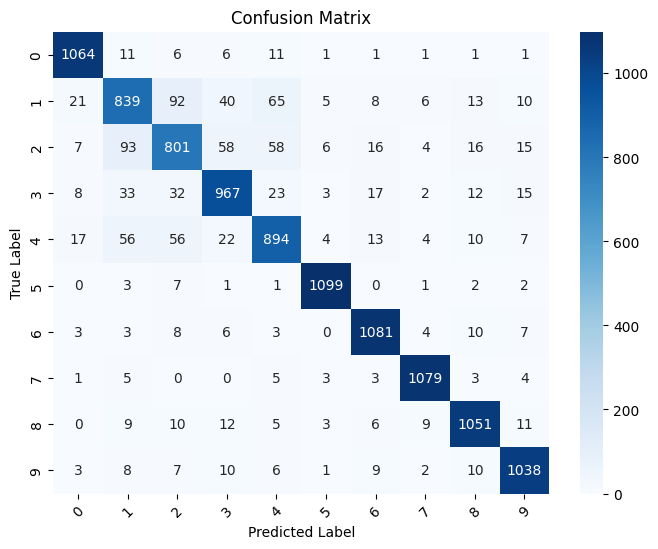

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


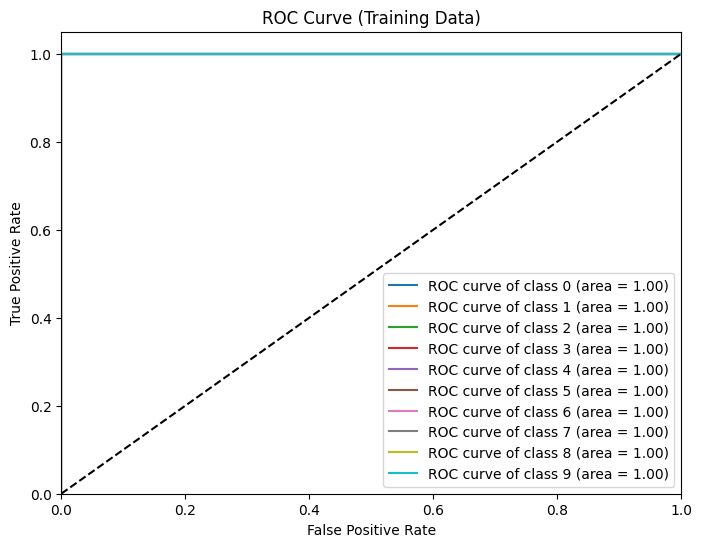

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7925783749200256
Precision: 0.7914327354046231
Recall (TPR): 0.7925783749200256
False Positive Rate (FPR): 0.023789556361072828
F1 score (F-measure): 0.7918113883734027
Specificity: 0.9762104436389272
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.983621,0.868613,0.894737,0.009886,0.881481,476,72,7211,56
1,1,0.913244,0.723276,0.701505,0.048497,0.712224,839,321,6298,357
2,2,0.904926,0.714165,0.677058,0.051645,0.695117,847,339,6225,404
3,3,0.940883,0.738624,0.764513,0.035787,0.751346,698,247,6655,215
4,4,0.928471,0.751912,0.768229,0.043824,0.759983,885,292,6371,267
5,5,0.989891,0.908922,0.942197,0.006716,0.925260,489,49,7247,30
6,6,0.978887,0.855787,0.835185,0.010447,0.845361,451,76,7199,89
7,7,0.988100,0.910280,0.915414,0.006591,0.912840,487,48,7235,45
8,8,0.976839,0.846278,0.858785,0.013183,0.852486,523,95,7111,86
9,9,0.980294,0.858864,0.873905,0.011320,0.866319,499,82,7162,72


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


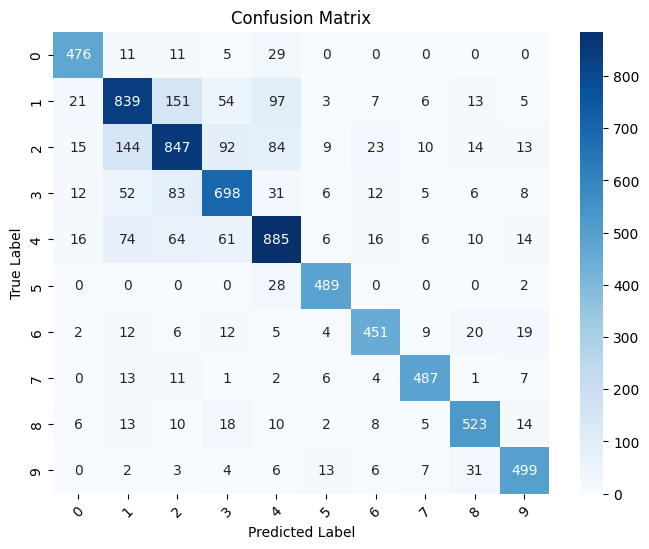

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


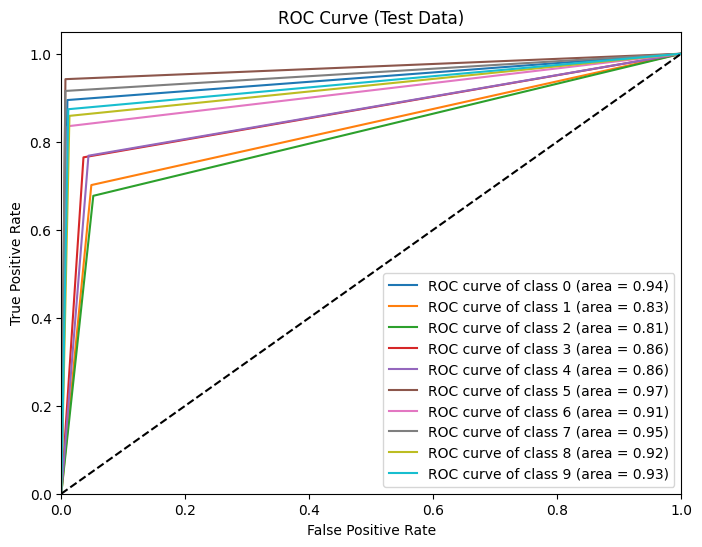

In [ ]:
print("Decision Tree classifier For 30% of the instances:")
print("------------------------------------------------------------------------------------------------")
dt_result_30 = runclassifier(clf_random,X_train_70, Y_train_70, X_test_combined, Y_test_combined)

ROC Curve Analysis

The ROC curves for the training and testing sets indicate strong discriminative ability across most classes, with areas under the curve (AUC) close to 1 for the training set and slightly less for the testing set, which is expected due to the model encountering previously unseen instances.

### 60% of the instances

In [ ]:
X_train_40,X_test_60, Y_train_40, Y_test_60 = train_test_split(X_train_stratified, y_train_stratified, train_size=0.4, test_size = 0.6, random_state=42)

In [ ]:
X_test_combined_60 = pd.concat([X_test_shuffled, X_test_60])
Y_test_combined_60 = pd.concat([Y_test_shuffled, Y_test_60])

Decision Tree classifier For 60% of the instances:
------------------------------------------------------------------------------------------------
Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.8604761904761905
Precision: 0.858904109617995
Recall (TPR): 0.8604761904761905
False Positive Rate (FPR): 0.01549173148337779
F1 score (F-measure): 0.8595753890167429
Specificity: 0.9845082685166222
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.983333,0.904687,0.929374,0.010745,0.916865,579,61,5616,44
1,1,0.945079,0.726115,0.723810,0.030335,0.724960,456,172,5498,174
2,2,0.942381,0.713287,0.672158,0.028807,0.692112,408,164,5529,199
3,3,0.962698,0.822504,0.808411,0.019795,0.815397,519,112,5546,123
4,4,0.960159,0.797297,0.782753,0.021064,0.789958,472,120,5577,131
5,5,0.991111,0.953198,0.959184,0.005298,0.956182,611,30,5633,26
6,6,0.983016,0.914197,0.918495,0.009714,0.916341,586,55,5607,52
7,7,0.990952,0.944359,0.966772,0.006351,0.955434,611,36,5632,21
8,8,0.980159,0.899543,0.909231,0.011681,0.904361,591,66,5584,59
9,9,0.982063,0.903226,0.921630,0.011127,0.912335,588,63,5599,50


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


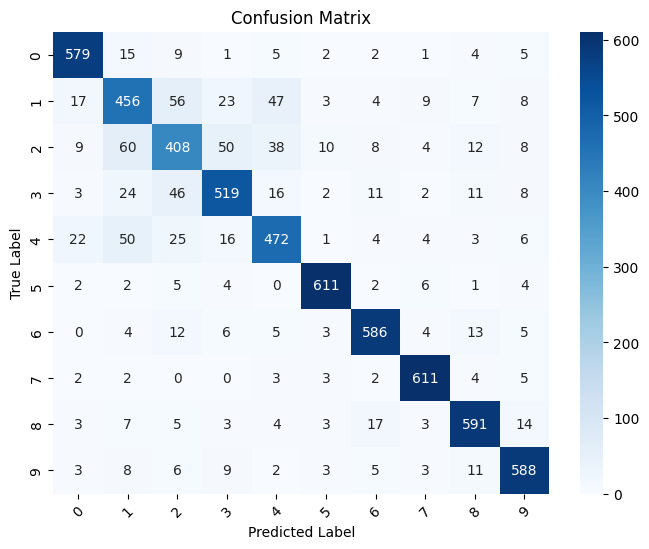

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


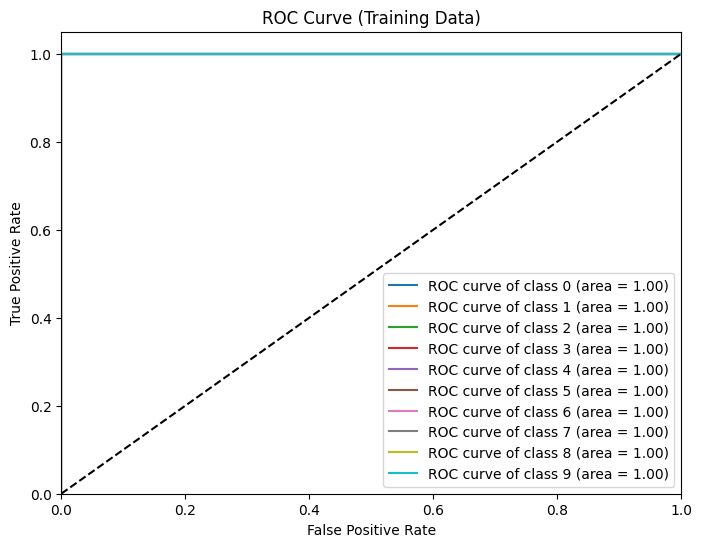

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7543186180422264
Precision: 0.7528576460795469
Recall (TPR): 0.7543186180422264
False Positive Rate (FPR): 0.028182513601947567
F1 score (F-measure): 0.7531090011467034
Specificity: 0.9718174863980524
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.978887,0.814751,0.892857,0.014829,0.852018,475,108,7175,57
1,1,0.896609,0.662479,0.661371,0.060885,0.661925,791,403,6216,405
2,2,0.890723,0.675199,0.611511,0.056063,0.641779,765,368,6196,486
3,3,0.932054,0.711752,0.703176,0.037670,0.707438,642,260,6642,271
4,4,0.907869,0.680301,0.707465,0.057482,0.693617,815,383,6280,337
5,5,0.988100,0.901887,0.921002,0.007127,0.911344,478,52,7244,41
6,6,0.977863,0.836697,0.844444,0.012234,0.840553,456,89,7186,84
7,7,0.987460,0.915709,0.898496,0.006041,0.907021,478,44,7239,54
8,8,0.972873,0.808709,0.853859,0.017069,0.830671,520,123,7083,89
9,9,0.976200,0.840708,0.831874,0.012424,0.836268,475,90,7154,96


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


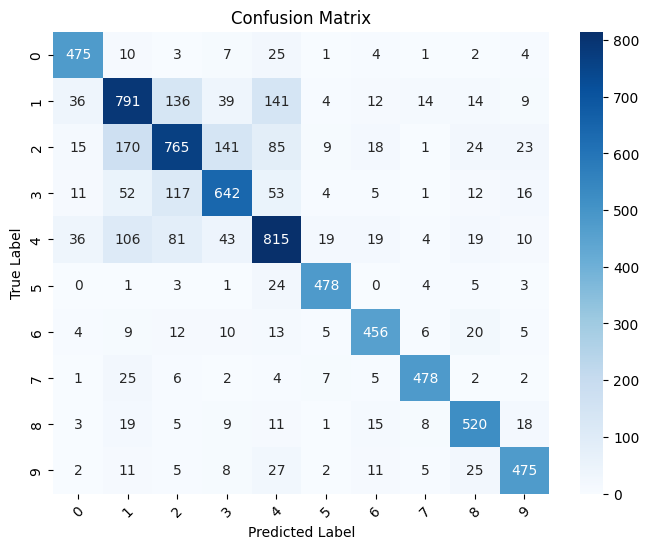

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


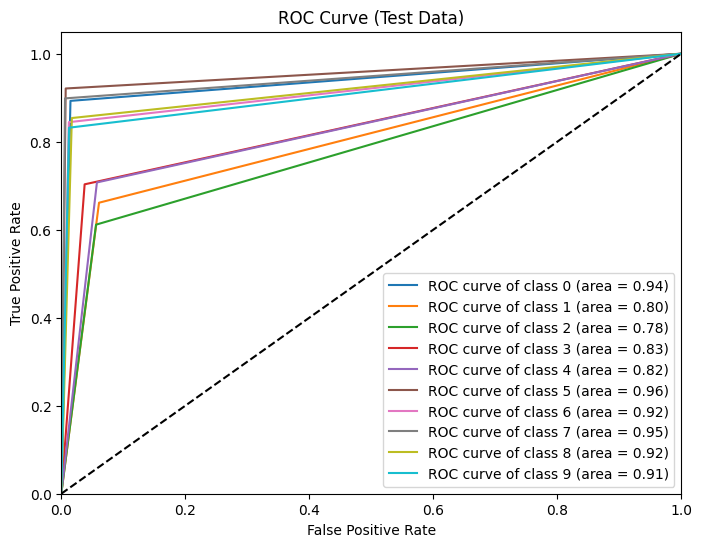

In [ ]:
print("Decision Tree classifier For 60% of the instances:")
print("------------------------------------------------------------------------------------------------")
dt_result_60 = runclassifier(clf_random,X_train_40, Y_train_40, X_test_combined, Y_test_combined)

ROC Curve Analysis:

The ROC curves for both training and testing sets suggest the model has a good ability to discriminate between classes. The AUC for the training set is perfect, while the AUC for the testing set shows some variability, indicating a slight drop in the model's discriminative power on the testing data.


Conclusion

After moving 30% and 60% of the training instances, we noticed the model performed relatively better on the new training and testing data sets.


### RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf_rfc = RandomForestClassifier(random_state=42)

### Running RandomForest Classifier on the training dataset without cross-validation

Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 1.0
Precision: 1.0
Recall (TPR): 1.0
False Positive Rate (FPR): 0.0
F1 score (F-measure): 1.0
Specificity: 1.0
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
1,1,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
2,2,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
3,3,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
4,4,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
5,5,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
6,6,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
7,7,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
8,8,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0
9,9,1.0,1.0,1.0,0.0,1.0,1575,0,14175,0


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


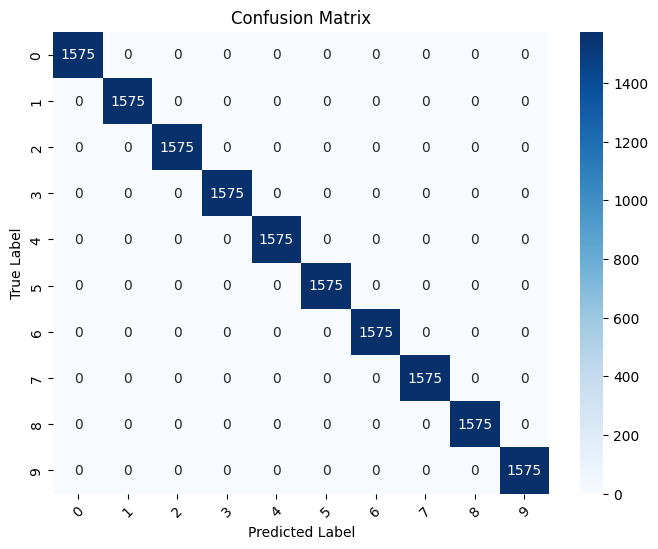

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


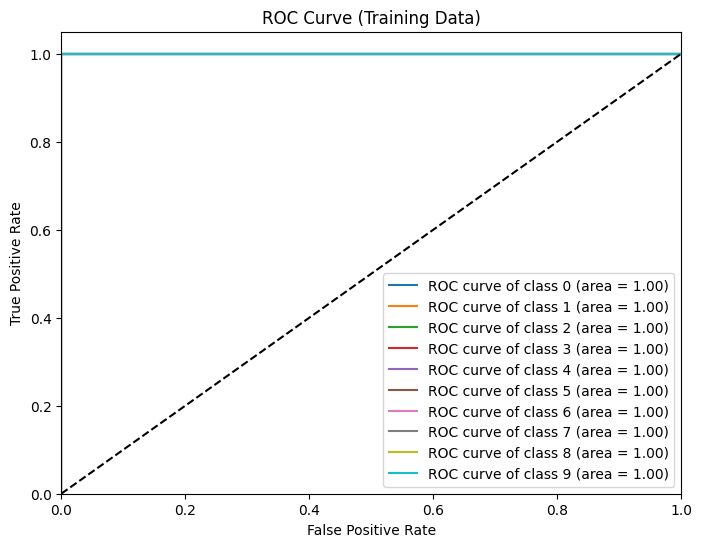

In [ ]:
labels_series = y_train_stratified['label']
unique_labels = sorted(labels_series.unique())

# Binarize the labels for ROC curve generation
y_train_bin = label_binarize(y_train_stratified, classes=unique_labels)

# Without Cross-Validation
clf_rfc.fit(X_train_stratified, y_train_stratified.values.ravel())

# Make predictions on the test data
y_train_pred = clf_rfc.predict(X_train_stratified)

# Overall metrics for training set
print("Overall Metrics for Training set:")
print("------------------------------------------------------------------------------------------------")
print_overall_metrics(y_train_stratified, y_train_pred)

# Display metrics in tabular format for each class
classwise_df_train = get_classwise_metrics_dataframe(y_train_stratified, y_train_pred, unique_labels)
print("\nClasswise Metrics for Training Set:")
display(classwise_df_train)

print("------------------------------------------------------------------------------------------------")
print("Confusion Matrix for Train Set")
print("------------------------------------------------------------------------------------------------")
plot_confusion_matrix(confusion_matrix(y_train_stratified, y_train_pred), 'Training Set', unique_labels)
print("------------------------------------------------------------------------------------------------")
print("ROC Curve for Train Set")
print("------------------------------------------------------------------------------------------------")
plot_roc_for_classes(y_train_bin, clf_rfc.predict_proba(X_train_stratified), unique_labels, title="ROC Curve (Training Data)")

The Random Forest classifier's performance without cross-validation indicates an almost perfect fit to the training data, with accuracy, precision, recall, F1 score, and specificity all at or near 100%. This level of performance, while ideal, raises concerns about overfitting, as it's highly unusual for a model to achieve such results unless it has memorized the training data rather than learning to generalize from

### Running the classifier with 10-fold cross validation

Random Forest classifier on clf:
------------------------------------------------------------------------------------------------


<ipython-input-18-2abb5298dfd5>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9895873015873016
Precision: 0.9895769070168695
Recall (TPR): 0.9895873015873016
False Positive Rate (FPR): 0.0011569664902998378
F1 score (F-measure): 0.9895750879458245
Specificity: 0.9988430335097002
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.999238,0.992439,1.000000,0.000847,0.996205,1575,12,14163,0
1,1,0.994159,0.967823,0.973968,0.003598,0.970886,1534,51,14124,41
2,2,0.993714,0.974903,0.961905,0.002751,0.968360,1515,39,14136,60
3,3,0.997524,0.986692,0.988571,0.001481,0.987631,1557,21,14154,18
4,4,0.995302,0.977721,0.975238,0.002469,0.976478,1536,35,14140,39
5,5,1.000000,1.000000,1.000000,0.000000,1.000000,1575,0,14175,0
6,6,0.999746,0.998730,0.998730,0.000141,0.998730,1573,2,14173,2
7,7,1.000000,1.000000,1.000000,0.000000,1.000000,1575,0,14175,0
8,8,0.999873,0.999365,0.999365,0.000071,0.999365,1574,1,14174,1
9,9,0.999619,0.998095,0.998095,0.000212,0.998095,1572,3,14172,3


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


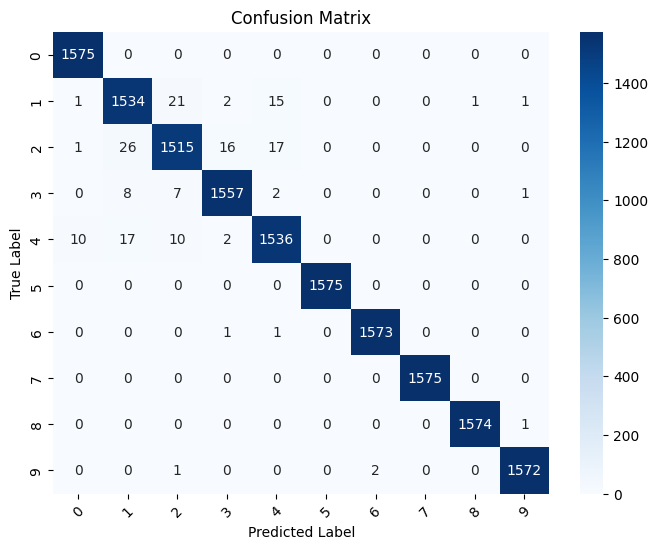

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


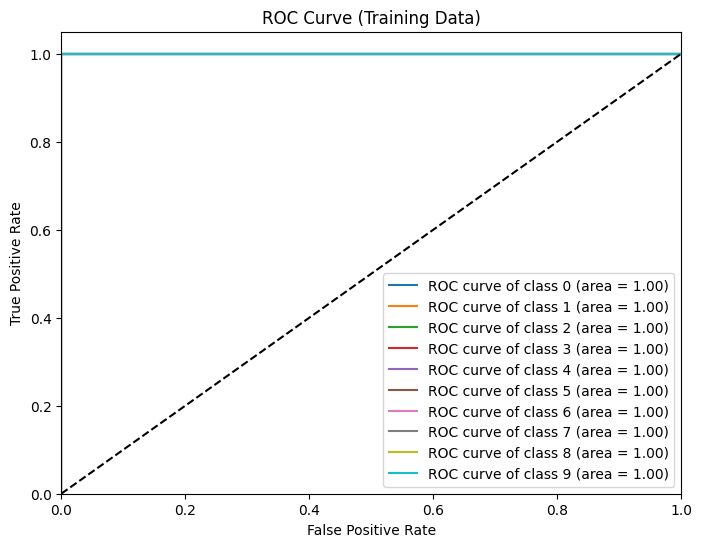

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7724919093851133
Precision: 0.7736240250338184
Recall (TPR): 0.7724919093851133
False Positive Rate (FPR): 0.02801013653317508
F1 score (F-measure): 0.7682961868632826
Specificity: 0.9719898634668249
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981553,0.565217,0.216667,0.003300,0.313253,13,10,3020,47
1,1,0.902589,0.762861,0.844444,0.079747,0.801582,608,189,2181,112
2,2,0.902913,0.810773,0.782667,0.058547,0.796472,587,137,2203,163
3,3,0.928155,0.728000,0.808889,0.051515,0.766316,364,136,2504,86
4,4,0.913592,0.807512,0.781818,0.050617,0.794457,516,123,2307,144
5,5,0.995793,0.927273,0.850000,0.001320,0.886957,51,4,3026,9
6,6,0.981877,0.697674,0.666667,0.008667,0.681818,60,26,2974,30
7,7,0.988673,0.931034,0.450000,0.000660,0.606742,27,2,3028,33
8,8,0.969903,0.664740,0.766667,0.019728,0.712074,115,58,2882,35
9,9,0.979935,0.718750,0.511111,0.006000,0.597403,46,18,2982,44


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


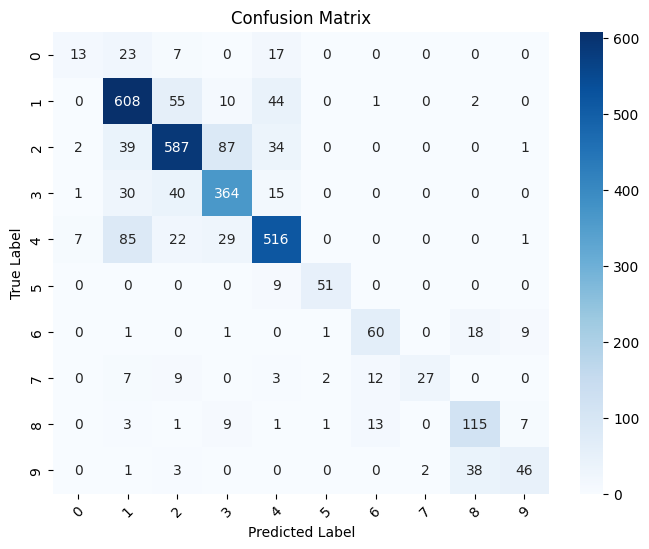

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


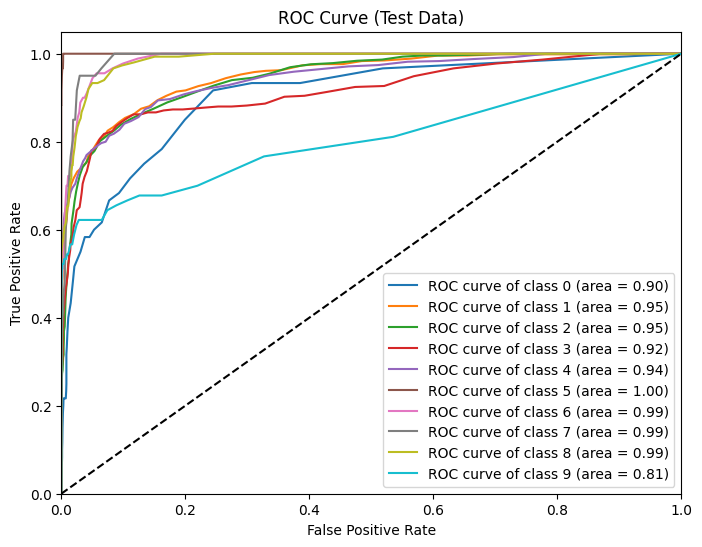

In [ ]:
print("Random Forest classifier using cross-validation:")
print("------------------------------------------------------------------------------------------------")
rf_result_stratified = runclassifier(clf_rfc,X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

When cross-validation is applied, the performance metrics of the Random Forest classifier become more realistic. The accuracy drops to around 98.9%, and other metrics show a similar decrease. This decline in performance is expected when transitioning from a training set to a validation set within cross-validation and suggests that the model's ability to generalize to new data is good but not perfect.

## HyperParameter Tuning

RandomForest hyperparamters :

* max_depth
* min_sample_split
* min_sample_leaf
* criterion
* n_estimators

### GridSearch

In [ ]:
def parametertuningrf(param_grid, X_train, y_train, X_test, y_test):

  labels_series = y_train['label']
  unique_labels = sorted(labels_series.unique())

  # Binarize the labels for ROC curve generation
  y_train_bin = label_binarize(y_train, classes=unique_labels)
  y_test_bin = label_binarize(y_test, classes=unique_labels)

  dt_clf = RandomForestClassifier(random_state=42)
  # GridSearch
  grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='accuracy')
  grid_search.fit(X_train, y_train)

  # Get the best parameter setting
  best_params = grid_search.best_params_
  best_model = grid_search.best_estimator_

  print("Best Parameters:", best_params)
  y_test_pred = best_model.predict(X_test)

  # Overall metrics for test set
  print("\nOverall Metrics for Test set:")
  print("------------------------------------------------------------------------------------------------")
  print_overall_metrics(y_test, y_test_pred)

  # Display metrics in tabular format for each class
  classwise_df_test = get_classwise_metrics_dataframe(y_test, y_test_pred, unique_labels)
  print("\nClasswise Metrics for Test Set:")
  display(classwise_df_test)

#  print("------------------------------------------------------------------------------------------------")
#  print("Confusion Matrix for Test Set")
#  print("------------------------------------------------------------------------------------------------")
#  plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), 'Test Set', unique_labels)
 # print("------------------------------------------------------------------------------------------------")
 # print("ROC Curve for Test Set")
 # print("------------------------------------------------------------------------------------------------")
 # plot_roc_for_classes(y_test_bin, best_model.predict_proba(X_test), unique_labels, title="ROC Curve (Test Data)")

  # Create metrics dictionary
  metrics_dict = {
      "Model": best_model.__class__.__name__,
      "Test Metrics": {
          "Accuracy": accuracy_score(y_test, y_test_pred),
          "Precision": precision_score(y_test, y_test_pred, average='weighted',zero_division=0),
          "Recall": recall_score(y_test, y_test_pred,average='weighted'),
          "F1 score": f1_score(y_test, y_test_pred, average='weighted'),
          "TP": confusion_matrix(y_test, y_test_pred).sum(axis=1),
          "FP": confusion_matrix(y_test, y_test_pred).sum(axis=0) - np.diag(confusion_matrix(y_test, y_test_pred)),
          "TN": confusion_matrix(y_test, y_test_pred).sum() - (confusion_matrix(y_test, y_test_pred).sum(axis=1) + confusion_matrix(y_test, y_test_pred).sum(axis=0)),
          "FN": np.diag(confusion_matrix(y_test, y_test_pred)),
          "Sensitivity (TPR)": recall_score(y_test, y_test_pred, average='weighted'),
          "Specificity": specificity(confusion_matrix(y_test, y_test_pred)),
          "FPR": 1 - specificity(confusion_matrix(y_test, y_test_pred))
          }
      }

  return metrics_dict

In [ ]:
max_depth_grid = {
    'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
}
print("For Checking the Maximum depth for the decision tree")
print("----------------------------------------------------------------------------")
depth_result = parametertuningrf(max_depth_grid,X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Maximum depth for the decision tree
----------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'max_depth': 19}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7754045307443366
Precision: 0.778222664982586
Recall (TPR): 0.7754045307443366
False Positive Rate (FPR): 0.02755331508519243
F1 score (F-measure): 0.7712663566263658
Specificity: 0.9724466849148076
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981877,0.571429,0.266667,0.003960,0.363636,16,12,3018,44
1,1,0.904207,0.767003,0.845833,0.078059,0.804491,609,185,2185,111
2,2,0.908091,0.829096,0.782667,0.051709,0.805213,587,121,2219,163
3,3,0.926861,0.717899,0.820000,0.054924,0.765560,369,145,2495,81
4,4,0.914887,0.809672,0.786364,0.050206,0.797848,519,122,2308,141
5,5,0.994822,0.879310,0.850000,0.002310,0.864407,51,7,3023,9
6,6,0.981230,0.677778,0.677778,0.009667,0.677778,61,29,2971,29
7,7,0.986731,0.952381,0.333333,0.000330,0.493827,20,1,3029,40
8,8,0.970550,0.676647,0.753333,0.018367,0.712934,113,54,2886,37
9,9,0.981553,0.739130,0.566667,0.006000,0.641509,51,18,2982,39


In [ ]:
min_sample_split_grid = {
   'min_samples_split': [2, 5, 10],
}
print("For Checking the Minimum number of splits for the decision tree")
print("----------------------------------------------------------------------------")
split_result = parametertuning(min_sample_split_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Minimum number of splits for the decision tree
----------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'min_samples_split': 2}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7724919093851133
Precision: 0.7736240250338184
Recall (TPR): 0.7724919093851133
False Positive Rate (FPR): 0.02801013653317508
F1 score (F-measure): 0.7682961868632826
Specificity: 0.9719898634668249
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981553,0.565217,0.216667,0.003300,0.313253,13,10,3020,47
1,1,0.902589,0.762861,0.844444,0.079747,0.801582,608,189,2181,112
2,2,0.902913,0.810773,0.782667,0.058547,0.796472,587,137,2203,163
3,3,0.928155,0.728000,0.808889,0.051515,0.766316,364,136,2504,86
4,4,0.913592,0.807512,0.781818,0.050617,0.794457,516,123,2307,144
5,5,0.995793,0.927273,0.850000,0.001320,0.886957,51,4,3026,9
6,6,0.981877,0.697674,0.666667,0.008667,0.681818,60,26,2974,30
7,7,0.988673,0.931034,0.450000,0.000660,0.606742,27,2,3028,33
8,8,0.969903,0.664740,0.766667,0.019728,0.712074,115,58,2882,35
9,9,0.979935,0.718750,0.511111,0.006000,0.597403,46,18,2982,44


In [ ]:
min_sample_leaf_grid = {
   'min_samples_leaf': [1, 2, 4],
}
print("For Checking the Minimum number of leafs for the decision tree")
print("----------------------------------------------------------------------------")
leaf_result = parametertuning(min_sample_leaf_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the Minimum number of leafs for the decision tree
----------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'min_samples_leaf': 1}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7724919093851133
Precision: 0.7736240250338184
Recall (TPR): 0.7724919093851133
False Positive Rate (FPR): 0.02801013653317508
F1 score (F-measure): 0.7682961868632826
Specificity: 0.9719898634668249
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981553,0.565217,0.216667,0.003300,0.313253,13,10,3020,47
1,1,0.902589,0.762861,0.844444,0.079747,0.801582,608,189,2181,112
2,2,0.902913,0.810773,0.782667,0.058547,0.796472,587,137,2203,163
3,3,0.928155,0.728000,0.808889,0.051515,0.766316,364,136,2504,86
4,4,0.913592,0.807512,0.781818,0.050617,0.794457,516,123,2307,144
5,5,0.995793,0.927273,0.850000,0.001320,0.886957,51,4,3026,9
6,6,0.981877,0.697674,0.666667,0.008667,0.681818,60,26,2974,30
7,7,0.988673,0.931034,0.450000,0.000660,0.606742,27,2,3028,33
8,8,0.969903,0.664740,0.766667,0.019728,0.712074,115,58,2882,35
9,9,0.979935,0.718750,0.511111,0.006000,0.597403,46,18,2982,44


In [ ]:
criterion_grid = {
   'criterion': ['gini', 'entropy'],
}
print("For Checking the criterion for the decision tree")
print("----------------------------------------------------------------------------")
criterion_result = parametertuning(criterion_grid, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the criterion for the decision tree
----------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'criterion': 'entropy'}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7776699029126214
Precision: 0.7790555960119645
Recall (TPR): 0.7776699029126214
False Positive Rate (FPR): 0.027383293649456464
F1 score (F-measure): 0.7725918342750394
Specificity: 0.9726167063505435
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981230,0.541667,0.216667,0.003630,0.309524,13,11,3019,47
1,1,0.904854,0.764925,0.854167,0.079747,0.807087,615,189,2181,105
2,2,0.909385,0.821918,0.800000,0.055556,0.810811,600,130,2210,150
3,3,0.933010,0.755789,0.797778,0.043939,0.776216,359,116,2524,91
4,4,0.917152,0.803303,0.810606,0.053909,0.806938,535,131,2299,125
5,5,0.995469,0.942308,0.816667,0.000990,0.875000,49,3,3027,11
6,6,0.979288,0.651163,0.622222,0.010000,0.636364,56,30,2970,34
7,7,0.987055,1.000000,0.333333,0.000000,0.500000,20,0,3030,40
8,8,0.966990,0.646341,0.706667,0.019728,0.675159,106,58,2882,44
9,9,0.980906,0.724638,0.555556,0.006333,0.628931,50,19,2981,40


In [ ]:
n_estimators_rf = {
    'n_estimators': [50, 100, 200, 300],
}

print("For Checking the criterion for the decision tree")
print("----------------------------------------------------------------------------")
leaf_result = parametertuning(n_estimators_rf, X_train_stratified, y_train_stratified, X_test_shuffled, Y_test_shuffled)

For Checking the criterion for the decision tree
----------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters: {'n_estimators': 300}

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.7815533980582524
Precision: 0.7830529210960572
Recall (TPR): 0.7815533980582524
False Positive Rate (FPR): 0.026836796805822738
F1 score (F-measure): 0.7771254644584544
Specificity: 0.9731632031941773
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.981230,0.550000,0.183333,0.002970,0.275000,11,9,3021,49
1,1,0.906472,0.768369,0.856944,0.078481,0.810243,617,186,2184,103
2,2,0.909385,0.833807,0.782667,0.050000,0.807428,587,117,2223,163
3,3,0.930744,0.731373,0.828889,0.051894,0.777083,373,137,2503,77
4,4,0.916181,0.813772,0.787879,0.048971,0.800616,520,119,2311,140
5,5,0.996764,0.946429,0.883333,0.000990,0.913793,53,3,3027,7
6,6,0.982524,0.704545,0.688889,0.008667,0.696629,62,26,2974,28
7,7,0.989320,0.935484,0.483333,0.000660,0.637363,29,2,3028,31
8,8,0.969903,0.662857,0.773333,0.020068,0.713846,116,59,2881,34
9,9,0.980583,0.734375,0.522222,0.005667,0.610390,47,17,2983,43


### After Hyperparameter Optimization

* max_depth': 19
* 'min_samples_split': 2
* 'min_samples_leaf' : 1
* 'criterion': 'entropy'
* 'n_estimators' : 300

Highest accuracy and F-Measure achieved is 78.15% and 0.77 respectively, so optimization of hyperparameters were done successfully.

### Randomized Search

In [ ]:
# setup parameter space
parameters = {'criterion':['gini','entropy'],
              'max_depth':poisson(mu=2,loc=2),
              'min_samples_split':uniform(),
              'max_leaf_nodes':poisson(mu=4,loc=3)}

# create an instance of the randomized search object
rf_r1 = RandomizedSearchCV(RandomForestClassifier(), parameters, cv=5, n_iter=100, random_state=42, n_jobs=-1)

# conduct grid search over the parameter space
#start_time = time.time()
rf_r1.fit(X_train_stratified,y_train_stratified)
#duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params2 = rf_r1.best_params_
# cls_params2['min_samples_split'] = np.ceil(cls_params2['min_samples_split']*X_train_stratified.shape[0])
cls_params2

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 11,
 'min_samples_split': 0.026366974497252005}

In [ ]:
model_rf = rf_r1.best_estimator_
y_pred = model_rf.predict(X_test_shuffled)
print('accuracy score: %.2f' % accuracy_score(Y_test_shuffled,y_pred))
print('precision score: %.2f' % precision_score(Y_test_shuffled, y_pred, average='weighted',zero_division=0))
print('recall score: %.2f' % recall_score(Y_test_shuffled, y_pred,average='weighted'))
print('f1 score: %.2f' % f1_score(Y_test_shuffled, y_pred,average='weighted'))
#print('computation time: %.2f' % duration)

accuracy score: 0.37
precision score: 0.42
recall score: 0.37
f1 score: 0.35


### Bayes Search

In [ ]:
# setup parameter space
parameters = {'criterion': Categorical(['gini','entropy']),
              'max_depth': Integer(1,21,prior='log-uniform'),
              'min_samples_split': Real(1e-3,1.0,prior='log-uniform'),
              'max_leaf_nodes': Integer(3,26,prior='uniform')}

# create an instance of the bayesian search object
b2_rf = BayesSearchCV(RandomForestClassifier(), parameters, cv=5, n_iter=10, random_state=42, n_jobs=-1)

# conduct randomized search over the parameter space
start_time = time.time()
b2_rf.fit(X_train_stratified,y_train_stratified)
duration = time.time() - start_time

# show best parameter configuration found for classifier
cls_params3 = b2_rf.best_params_
#cls_params3['min_samples_split'] = np.ceil(cls_params3['min_samples_split']*X_train_stratified.shape[0])
cls_params3

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


OrderedDict([('criterion', 'gini'),
             ('max_depth', 8),
             ('max_leaf_nodes', 23),
             ('min_samples_split', 0.017679226616446445)])

In [ ]:
model = b2_rf.best_estimator_
y_pred = model.predict(X_test_shuffled)
print('accuracy score: %.2f' % accuracy_score(Y_test_shuffled,y_pred))
print('precision score: %.2f' % precision_score(Y_test_shuffled, y_pred, average='weighted',zero_division=0))
print('recall score: %.2f' % recall_score(Y_test_shuffled, y_pred,average='weighted'))
print('f1 score: %.2f' % f1_score(Y_test_shuffled, y_pred,average='weighted'))
print('computation time: %.2f' % duration)

accuracy score: 0.52
precision score: 0.65
recall score: 0.52
f1 score: 0.54
computation time: 1136.65



## Testing the 60% and 30% training instances on RandomForest Classifier



RandomForest classifier For 30% of the instances:
------------------------------------------------------------------------------------------------


<ipython-input-18-2abb5298dfd5>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9831292517006802
Precision: 0.9831035187192856
Recall (TPR): 0.9831292517006802
False Positive Rate (FPR): 0.0018731940042846507
F1 score (F-measure): 0.9830724455115049
Specificity: 0.9981268059957153
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.998458,0.985689,0.999093,0.001613,0.992346,1102,16,9906,1
1,1,0.991746,0.959016,0.958144,0.004534,0.958580,1053,45,9881,46
2,2,0.990023,0.964355,0.932030,0.003718,0.947917,1001,37,9914,73
3,3,0.994467,0.962181,0.983813,0.004338,0.972877,1094,43,9870,18
4,4,0.993832,0.970343,0.966759,0.003219,0.968548,1047,32,9910,36
5,5,0.999819,0.998211,1.000000,0.000202,0.999105,1116,2,9907,0
6,6,0.999274,0.996444,0.996444,0.000404,0.996444,1121,4,9896,4
7,7,1.000000,1.000000,1.000000,0.000000,1.000000,1103,0,9922,0
8,8,0.999637,0.998208,0.998208,0.000202,0.998208,1114,2,9907,2
9,9,0.999002,0.995425,0.994516,0.000503,0.994970,1088,5,9926,6


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


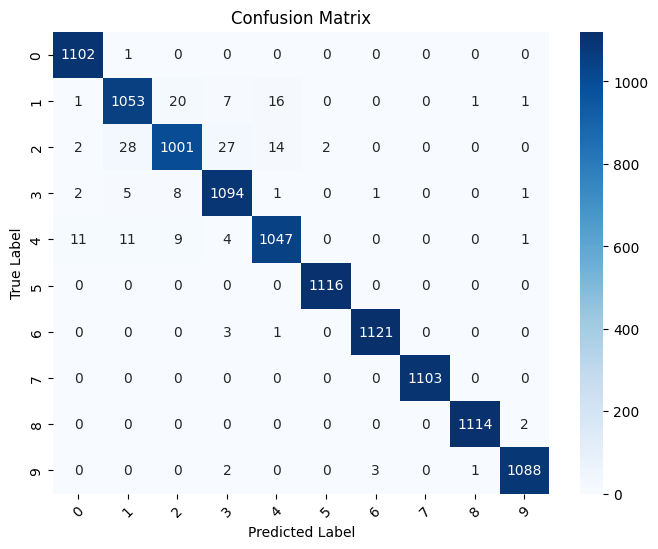

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


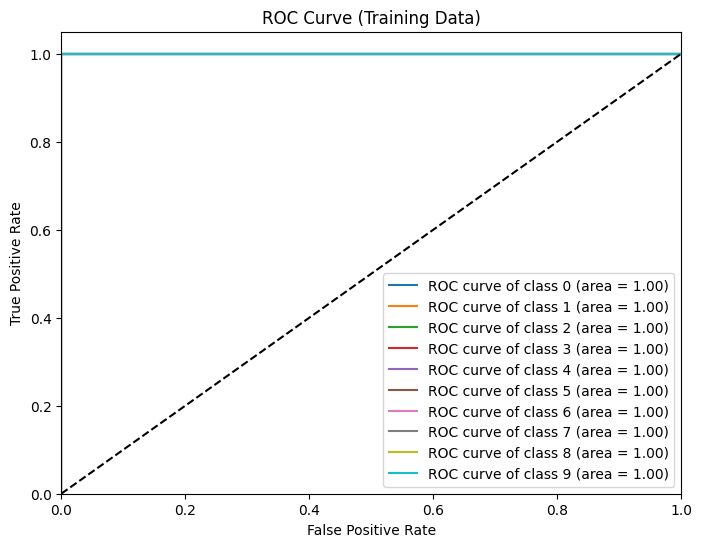

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.890978886756238
Precision: 0.8931146742726096
Recall (TPR): 0.890978886756238
False Positive Rate (FPR): 0.012586514382036063
F1 score (F-measure): 0.8914974670083916
Specificity: 0.9874134856179639
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.991555,0.962302,0.911654,0.002609,0.936293,485,19,7264,47
1,1,0.950480,0.819258,0.867893,0.034597,0.842875,1038,229,6390,158
2,2,0.950352,0.865988,0.816147,0.024071,0.840329,1021,158,6406,230
3,3,0.961356,0.808898,0.876232,0.027383,0.841220,800,189,6713,113
4,4,0.962636,0.875874,0.869792,0.021312,0.872822,1002,142,6521,150
5,5,0.998337,0.992218,0.982659,0.000548,0.987415,510,4,7292,9
6,6,0.991683,0.940631,0.938889,0.004399,0.939759,507,32,7243,33
7,7,0.995521,0.994036,0.939850,0.000412,0.966184,500,3,7280,32
8,8,0.987844,0.906646,0.940887,0.008188,0.923449,573,59,7147,36
9,9,0.992194,0.968750,0.922942,0.002347,0.945291,527,17,7227,44


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


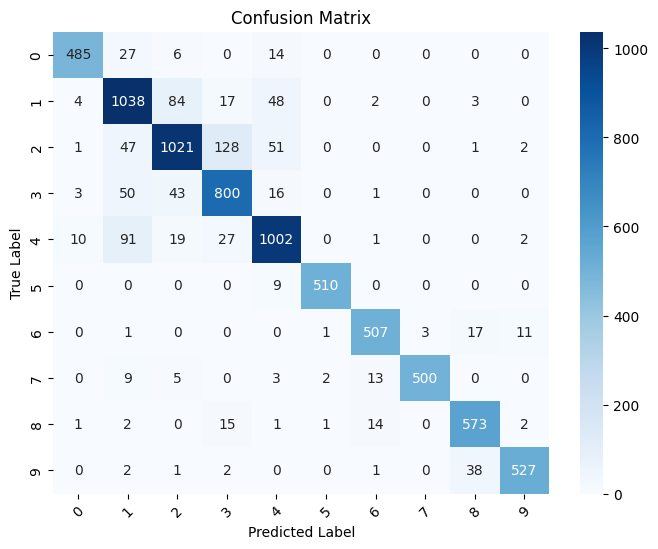

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


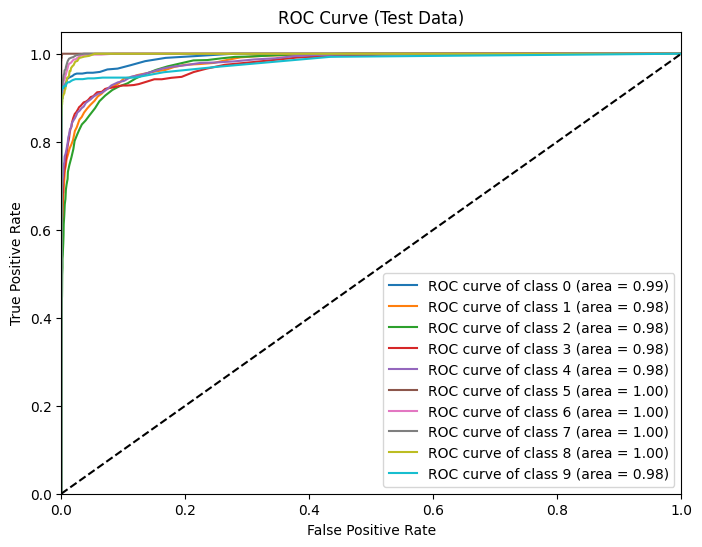

In [ ]:
print("RandomForest classifier For 30% of the instances:")
print("------------------------------------------------------------------------------------------------")
rf_result_30 = runclassifier(clf_rfc,X_train_70, Y_train_70, X_test_combined, Y_test_combined)

RandomForest classifier for 60% of the instances:
------------------------------------------------------------------------------------------------


<ipython-input-18-2abb5298dfd5>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1068: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_s

Overall Metrics for Training set:
------------------------------------------------------------------------------------------------
Accuracy: 0.9712698412698413
Precision: 0.9713217127801687
Recall (TPR): 0.9712698412698413
False Positive Rate (FPR): 0.003188652368934397
F1 score (F-measure): 0.9711689465887792
Specificity: 0.9968113476310656
------------------------------------------------------------------------------------------------

Classwise Metrics for Training Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.997778,0.982567,0.995185,0.001938,0.988836,620,11,5666,3
1,1,0.985556,0.943987,0.909524,0.005996,0.926435,573,34,5636,57
2,2,0.983810,0.925801,0.904448,0.007729,0.915000,549,44,5649,58
3,3,0.989683,0.924890,0.978193,0.009014,0.950795,628,51,5607,14
4,4,0.989683,0.949833,0.941957,0.005266,0.945878,568,30,5667,35
5,5,0.999841,1.000000,0.998430,0.000000,0.999214,636,0,5663,1
6,6,0.999048,0.996855,0.993730,0.000353,0.995290,634,2,5660,4
7,7,0.999683,0.996845,1.000000,0.000353,0.998420,632,2,5666,0
8,8,0.998254,0.993818,0.989231,0.000708,0.991519,643,4,5646,7
9,9,0.999206,0.995305,0.996865,0.000530,0.996085,636,3,5659,2


------------------------------------------------------------------------------------------------
Confusion Matrix for Train Set
------------------------------------------------------------------------------------------------


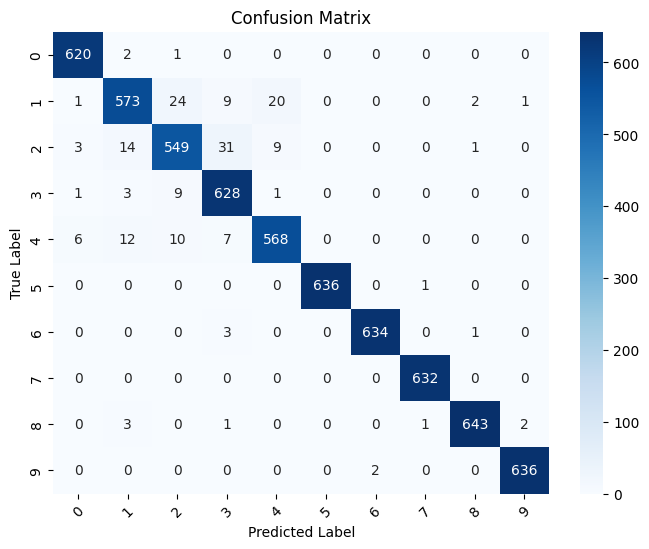

------------------------------------------------------------------------------------------------
ROC Curve for Train Set
------------------------------------------------------------------------------------------------


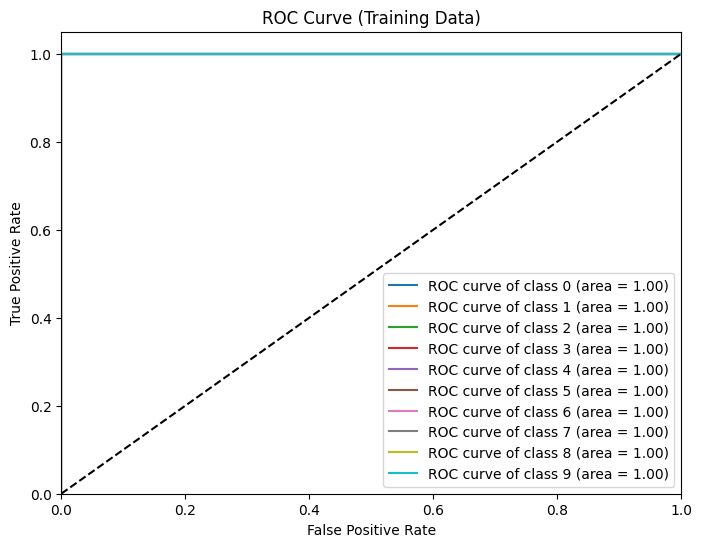

------------------------------------------------------------------------------------------------

Overall Metrics for Test set:
------------------------------------------------------------------------------------------------
Accuracy: 0.8715291106845809
Precision: 0.873743158911989
Recall (TPR): 0.8715291106845809
False Positive Rate (FPR): 0.014811596099643554
F1 score (F-measure): 0.8715660019894962
Specificity: 0.9851884039003564
------------------------------------------------------------------------------------------------

Classwise Metrics for Test Set:


,Class,Accuracy,Precision,Recall (TPR),FPR,F1 Score (F-measure),TP,FP,TN,FN
0,0,0.990019,0.923507,0.930451,0.005630,0.926966,495,41,7242,37
1,1,0.945361,0.810833,0.838629,0.035353,0.824497,1003,234,6385,193
2,2,0.934613,0.830948,0.742606,0.028793,0.784297,929,189,6375,322
3,3,0.955470,0.767773,0.887185,0.035497,0.823171,810,245,6657,103
4,4,0.953167,0.845951,0.834201,0.026264,0.840035,961,175,6488,191
5,5,0.998081,0.986486,0.984586,0.000959,0.985535,511,7,7289,8
6,6,0.990659,0.933210,0.931481,0.004948,0.932345,503,36,7239,37
7,7,0.995521,0.992079,0.941729,0.000549,0.966249,501,4,7279,31
8,8,0.987332,0.903481,0.937603,0.008465,0.920226,571,61,7145,38
9,9,0.992834,0.977737,0.922942,0.001657,0.949550,527,12,7232,44


------------------------------------------------------------------------------------------------
Confusion Matrix for Test Set
------------------------------------------------------------------------------------------------


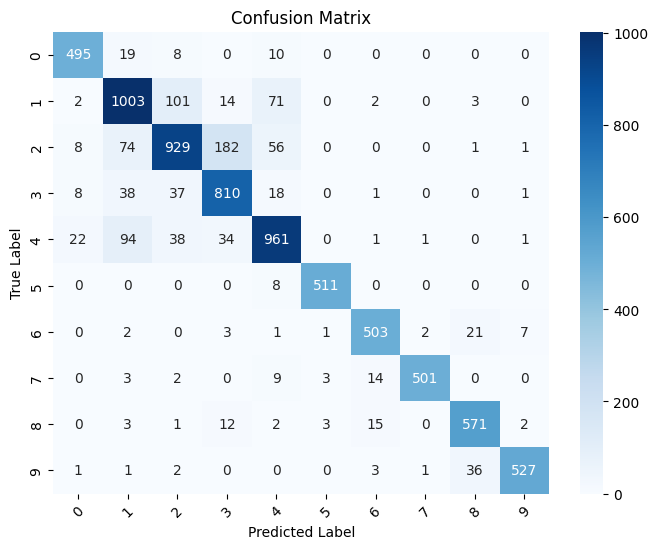

------------------------------------------------------------------------------------------------
ROC Curve for Test Set
------------------------------------------------------------------------------------------------


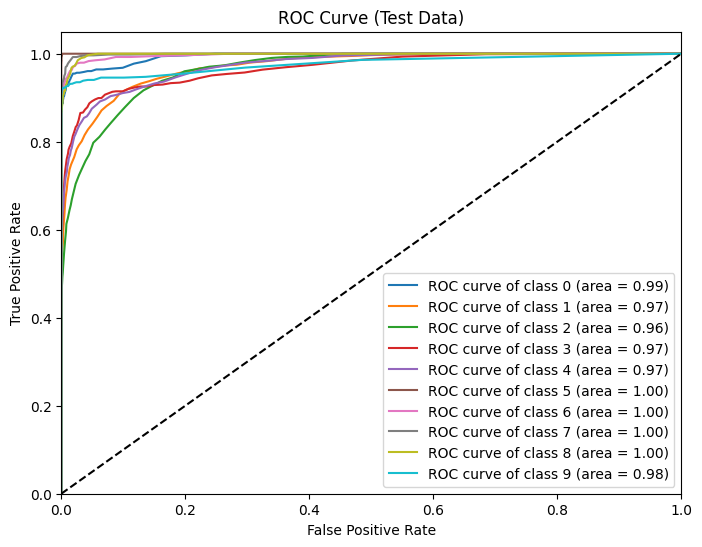

In [ ]:
print("RandomForest classifier for 60% of the instances:")
print("------------------------------------------------------------------------------------------------")
rf_result_60 = runclassifier(rf_clf,X_train_40, Y_train_40, X_test_combined, Y_test_combined)

The metrics for the RandomForest classifier trained on 30% and 60% of the available data demonstrate robust and high performance across various classes, which suggests that the model is effectively capturing the underlying patterns in the data without overfitting.

* Accuracy is above 98% for the 30% training instance, indicating that regardless of the smaller size of the training data, the model is able to make correct predictions for a very high percentage of the cases.

* The classwise metrics show consistently high precision and recall across all classes for both training instances. This suggests that the RandomForest model does not favor any particular class and is able to generalize its learning across different categories of data.

* The F1 Score, remains high in both instances, indicating a balanced classification performance even when the amount of data is varied.

* Both training instances show a very low False Positive Rate (FPR), which is crucial in applications where false positives can have serious consequences.

* The confusion matrices illustrate a high number of true positives (TP) and true negatives (TN) across all classes, with very few false positives (FP) and false negatives (FN), reinforcing the classifier's accuracy.





## Comparison between Random Forest and Decision Tree Classifier

*	Comparing the Random Forest to the Decision Tree classifier, both displayed signs of overfitting when assessed without cross-validation, with perfect metrics across all classes. However, under the scrutiny of 10-fold cross-validation, both classifiers experienced a decrease in performance, with the Random Forest classifier generally maintaining a higher accuracy than the Decision Tree. This is indicative of the Random Forest's inherent mechanisms for reducing overfitting, such as using multiple decision trees to average predictions, which typically offers better generalization than a single decision tree as in the Decision Tree algorithm.
*	Decision Tree might produce a simpler model that is easier to interpret, but this comes at the cost of model robustness and potentially accuracy. The high performance metrics of the RandomForest, are likely due to its ensemble nature, which mitigates the risk of errors from an individual tree.
*	In summary, the high performance of the RandomForest classifier in both the 30% and 60% training instances, as shown above, is likely to surpasses what a Decision Tree classifier could achieve due to the inherent strengths of the ensemble methods in capturing complex patterns and reducing overfitting.
